In [1]:
import os
import pickle
import scipy.io as io

import sys

sys.path.append('..')

from tepfit.fit import ParamsJR, Model_fitting, RNNJANSEN, Costs, OutputNM

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import time
import torch
import torch.optim as optim
from torch.nn.parameter import Parameter

sns.set()

In [2]:
# declare all the variables in one place
sc_file = '../data/Schaefer2018_200Parcels_7Networks_count.csv'         # 200x200 matrix
high_file = '../data/only_high_trial.mat'                               # 20x62x2000 matrix
dist_file = '../data/Schaefer2018_200Parcels_7Networks_distance.csv'    # 200x200 matrix
file_labels = '../data/label_ts_corrected'                              # 200x2000 matrix
file_leadfield = '../data/leadfield'                                    # 62x200 matrix
file_eeg = '../data/real_EEG'                                           # 62x2000 matrix
stim_weights_file = '../data/stim_weights.npy'                          # 200 vector

# open leadfield matrix file
lm = np.load(file_leadfield, allow_pickle=True)

# gm is the same shape as lm, gm = grand mean structural connectome from 400 HCP age=[21, 35]
gm = lm

# show the shape
print(gm.shape)

(62, 200)


In [3]:
# open files
eeg = np.load(file_eeg, allow_pickle=True)
data_high = io.loadmat(high_file)
stim_weights = np.load(stim_weights_file)

sc_df = pd.read_csv(sc_file, header=None, sep=' ')
sc = sc_df.values
sc = 0.5 * (sc + sc.T)
sc =np.log1p(sc) / np.linalg.norm(np.log1p(sc))

dist_df = pd.read_csv(dist_file, header=None, sep=' ')
dist = dist_df.values

ki0 = stim_weights[:, np.newaxis]

print('ki0 shape:', ki0.shape)
print(f'Leadfield min: {lm.min()}, max: {lm.max()}')
print('High trial shape:', data_high['only_high_trial'].shape)

ki0 shape: (200, 1)
Leadfield min: -125.8151626586914, max: 268.3122253417969
High trial shape: (20, 62, 2000)


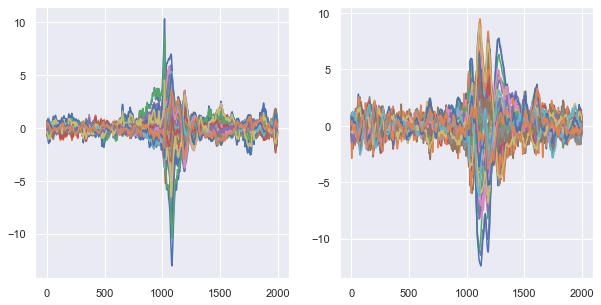

In [4]:
# visualize high trial 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(data_high['only_high_trial'][0].T)
ax[1].plot(data_high['only_high_trial'][6].T)
plt.show()

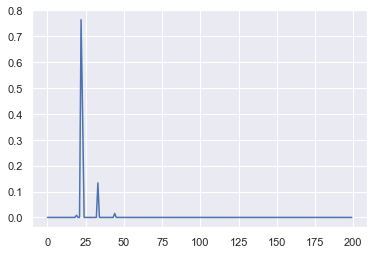

In [5]:
plt.plot(ki0)
plt.show()

u.shape: (200, 10, 400)
epoch: 0 loss: -3721.1724
		Correlation coefficient: 0.29443150722201156 		cos_sim: 0.10239556532968636

epoch: 10 loss: -18117.102
		Correlation coefficient: 0.6536691158087962 		cos_sim: 0.14623629947106606

epoch: 20 loss: -23064.645
		Correlation coefficient: 0.7125762086319689 		cos_sim: 0.33607491590615046

epoch: 30 loss: -26232.184
		Correlation coefficient: 0.747770694258872 		cos_sim: 0.5808656161200512

epoch: 40 loss: -28588.215
		Correlation coefficient: 0.7598475186194911 		cos_sim: 0.7431319153780694

epoch: 50 loss: -30473.385
		Correlation coefficient: 0.7766918870832676 		cos_sim: 0.7798542318882589

epoch: 60 loss: -32051.17
		Correlation coefficient: 0.7877712261099171 		cos_sim: 0.7916596679403974

epoch: 70 loss: -33411.99
		Correlation coefficient: 0.8064923947271257 		cos_sim: 0.8011417571752459

epoch: 80 loss: -34611.395
		Correlation coefficient: 0.8233344578203834 		cos_sim: 0.8092730686062318

epoch: 90 loss: -35685.465
		Correlation

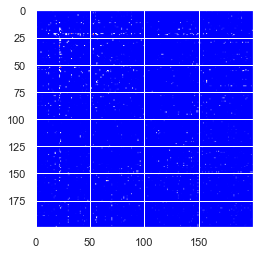

In [6]:
# start timing to see how long the model trains
start_time = time.time()

node_size = stim_weights.shape[0]

# output should be a TS with 200 values to match empirical data (this would be used as Y-axis for some reason)
output_size = gm.shape[0]

# model specs
batch_size = 50            # how big the "sample size" on each training iteration
step_size = 0.0001         # how much to change on each iteration
input_size = 3             # starting 3rd dimension (responsible for depth)
num_epoches = 120          # how long to train the model for
state_size = 6             # random state to make the model "reproducible"
base_batch_num = 20

# integration step
tr = 0.001

# the output will match 62x200 dims
lm_v = np.zeros((output_size, node_size))

# create output path
output = '../leadfield_from_mne'

if not os.path.exists(output):
    os.mkdir(output)


########################################################
###                   START TRAINING                 ###
########################################################

# uncomment and change N if you want several subjects + use indentation
# N = 20
# for i in range(N):

i = 0
data_mean = np.array([data_high['only_high_trial'][i]] * num_epoches)

# create parameters for Jansen-Rit model 
par = ParamsJR('JR', A = [3.25, 0], a= [100, 0.5], B = [22, 0], b = [50, 1], g=[1000, .1], 
               c1 = [135, 0.2], c2 = [135*0.8, 0.4], c3 = [135*0.25, 0.8], c4 = [135*0.25, 0.8],
               std_in=[100, 10], vmax= [5, 0], v0=[6,0], r=[0.56, 0], y0=[2 * np.ones((output_size, 1)), 2 * np.ones((output_size, 1))],\
               mu = [1., 2.5], k = [10, .3], cy0 = [5, 0], ki=[ki0, 0], lm=[lm, 1.0 * np.ones((output_size, node_size))+lm_v],
               w_bb=[sc, 50 * np.ones((node_size, node_size))])

# create a Jansen-Rit model
model = RNNJANSEN(input_size, node_size, batch_size, step_size, output_size, tr, sc, lm, dist, 
                  fit_gains_flat=True, fit_lfm_flat=False, param=par)

# fit the model for 120 epochs, 
F = Model_fitting(model, data_mean[:,:,900:1300], num_epoches, cost=0)

# fit train data
u = np.zeros((node_size, 10, 400))
print('u.shape:', u.shape)
u[:, :, 110:120] = 1000
output_train = F.train(u=u)

u = np.zeros((node_size,10,400))
u[:,:,110:120]= 1000
X0 = np.random.uniform(0, 5, (node_size, state_size))
hE0 = np.random.uniform(0, 5, (node_size, 500))

output_test = F.test(X0, hE0, base_batch_num, u=u)

sc_mod = np.zeros((200,200))
mask = np.tril_indices(200,-1)


sc_mod[mask] = F.output_sim.weights[-10:,:].mean(0)
sc_mod = sc_mod+sc_mod.T
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.imshow(np.log1p(sc_mod), cmap = 'bwr')
plt.show()

end_time =  time.time()
print('running time is  {0} \'s'.format(end_time - start_time ))

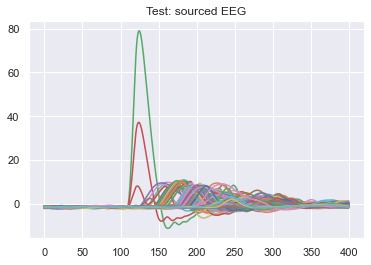

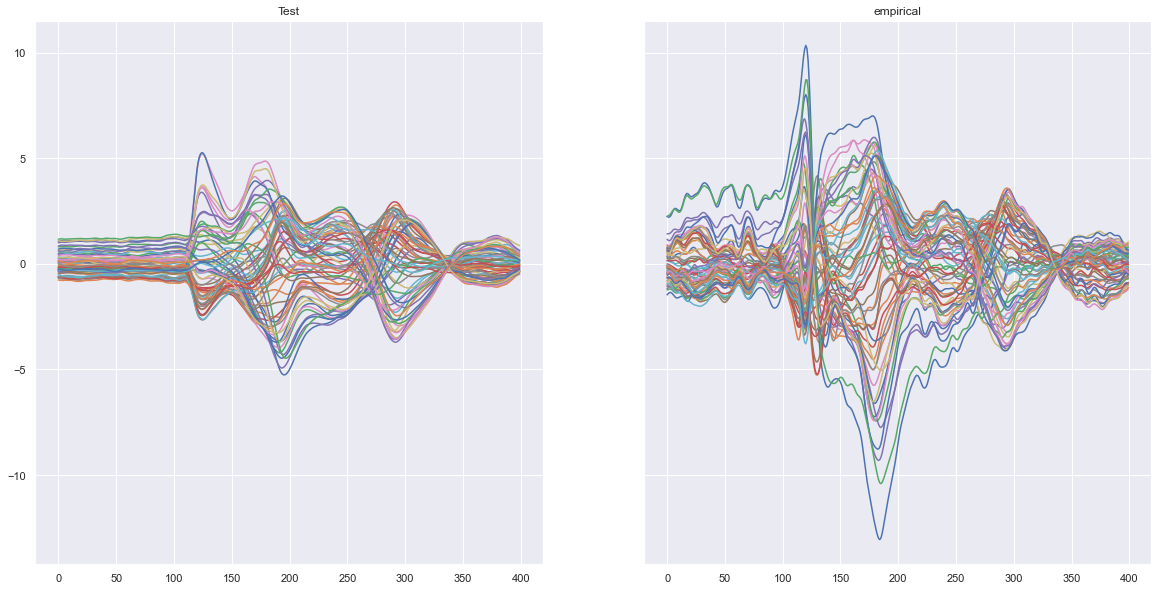

In [13]:
# save output
filename = '../data/sub_' + str(i) + '_fittingresults_stim_exp.pkl'
with open(filename, 'wb') as f:
    pickle.dump(F, f)

outfilename = '../data/sub_' + str(i) + '_simEEG_stim_exp.pkl'

with open(outfilename, 'wb') as f:
    pickle.dump(F.output_sim, f)

plt.plot((F.output_sim.E_test-F.output_sim.I_test).T)
plt.title('Test: sourced EEG')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
ax[0].plot(F.output_sim.eeg_test.T)
ax[0].set_title('Test')
ax[1].plot(data_high['only_high_trial'][i].T[900:1300,:])
ax[1].set_title('empirical')
plt.show()